# Hinton Version - "Vanilla" Model

## Architecture - always execute this

In [ ]:
%%writefile models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class TeacherNet(nn.Module):
    """
    Teacher network for CIFAR-10: A standard CNN.
    Using 3 channels and spatial convolutions instead of flat linear layers.
    """
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # After 3 rounds of MaxPool (32->16->8->4), the feature map is 4x4
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, temperature=1.0):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)

        return F.softmax(logits / temperature, dim=1), logits


class StudentNet(nn.Module):
    """
    Student network for CIFAR-10: A smaller/thinner CNN.
    Reduces the number of filters and layers to be more efficient.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # After 2 rounds of MaxPool (32->16->8), the feature map is 8x8
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x, temperature=1.0):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)

        return F.softmax(logits / temperature, dim=1), logits


def distillation_loss(student_logits, teacher_soft_targets, hard_targets,
                      temperature, alpha=0.5):
    """
    Loss function remains identical as it is mathematically agnostic to
    image dimensions or model depth.
    """
    student_soft = F.log_softmax(student_logits / temperature, dim=1)
    soft_loss = F.kl_div(student_soft, teacher_soft_targets, reduction='batchmean')
    soft_loss = soft_loss * (temperature ** 2)

    hard_loss = F.cross_entropy(student_logits, hard_targets)

    return alpha * hard_loss + (1 - alpha) * soft_loss

Writing models.py


In [ ]:
import torch
import time
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models import TeacherNet, StudentNet, distillation_loss

def get_cifar10_loaders(batch_size=128):
    """
    Helper to get CIFAR-10 loaders with standard data augmentation.
    """
    # CIFAR-10 normalization values
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*stats),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats),
    ])

    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader


def train_teacher(model, train_loader, epochs=20, lr=0.001):
    """Train the teacher model. Increased default epochs for CIFAR-10."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    # CIFAR often benefits from weight decay to prevent overfitting
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            _, logits = model(data)
            loss = torch.nn.functional.cross_entropy(logits, target)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Teacher Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    return model

# train_student_normal and train_student_distilled logic remains the same
# as they call the models and distillation_loss we updated in Section 1.

def evaluate(model, test_loader):
    """Evaluate model accuracy"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # Temperature 1.0 for standard inference
            outputs, _ = model(data, temperature=1.0)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    errors = total - correct
    return accuracy, errors

In [ ]:
import os
import time
import torch
import shutil
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models import TeacherNet, StudentNet, distillation_loss

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    # Hyperparameters updated for CIFAR-10
    dropout = 0.3
    epochs = 20  # CIFAR-10 needs at least 20-30 epochs to see meaningful KD results
    temp = 4.0   # Hinton's paper found lower T (like 4-5) often works better for complex data
    lr = 0.001
    batch_size = 128 # Smaller batch size than MNIST to fit CNN feature maps in memory

    # Data loading for CIFAR-10
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*stats),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats),
    ])

    train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10('./data', train=False, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                               num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                num_workers=2, pin_memory=True)

    print("=" * 60)
    print("CIFAR-10 Knowledge Distillation Experiment")
    print("=" * 60)

    # 1. Train Teacher
    print("\n[1/4] Training Teacher CNN...")
    teacher = TeacherNet(dropout_rate=dropout)
    teacher = train_teacher(teacher, train_loader, epochs=epochs, lr=lr)
    teacher_acc, teacher_err = evaluate(teacher, test_loader)
    print(f"✓ Teacher: {teacher_acc:.2f}% accuracy ({teacher_err} errors)")

    # 2. Train Student Normally
    print("\n[2/4] Training Student CNN Normally (Baseline)...")
    student_normal = StudentNet()
    student_normal = train_student_normal(student_normal, train_loader, epochs=epochs, lr=lr)
    student_normal_acc, student_normal_err = evaluate(student_normal, test_loader)
    print(f"✓ Student (normal): {student_normal_acc:.2f}% accuracy ({student_normal_err} errors)")

    # 3. Train Student with Distillation
    print(f"\n[3/4] Training Student with Distillation (T={temp}, alpha=0.1)...")
    student_distilled = StudentNet()
    student_distilled = train_student_distilled(student_distilled, teacher, train_loader,
                                                temperature=temp, alpha=0.1, epochs=epochs, lr=lr)
    student_distilled_acc, student_distilled_err = evaluate(student_distilled, test_loader)
    print(f"✓ Student (distilled): {student_distilled_acc:.2f}% accuracy ({student_distilled_err} errors)")

    # 4. Results Summary
    print("\n" + "=" * 60)
    print("RESULTS SUMMARY (CIFAR-10)")
    print("=" * 60)
    print(f"Teacher CNN:            {teacher_err:4d} test errors ({teacher_acc:.2f}%)")
    print(f"Student normal:         {student_normal_err:4d} test errors ({student_normal_acc:.2f}%)")
    print(f"Student distilled:      {student_distilled_err:4d} test errors ({student_distilled_acc:.2f}%)")
    print("=" * 60)

    # 5. Inference Speed Test (logic remains the same)
    print("\n" + "=" * 60)
    print("INFERENCE SPEED TEST")
    print("=" * 60)

    sample = next(iter(test_loader))[0][:1].to(device)

    def count_params(model):
        return sum(p.numel() for p in model.parameters())

    def benchmark(model, name):
        model.eval()
        params = count_params(model)
        with torch.no_grad():
            for _ in range(10): model(sample)
            if torch.cuda.is_available(): torch.cuda.synchronize()
            start = time.time()
            for _ in range(1000): model(sample)
            if torch.cuda.is_available(): torch.cuda.synchronize()
            ms = (time.time() - start) # result is in seconds, *1000/1000 cancels out
        print(f"{name:25s}: {ms:.3f} ms/sample  ({params:,} params)")
        return ms

    t_time = benchmark(teacher, "Teacher CNN")
    s_time = benchmark(student_normal, "Student CNN")
    d_time = benchmark(student_distilled, "Distilled CNN")

    print(f"\nSpeedup: {t_time/s_time:.2f}x faster")
    print("=" * 60)

    # 6. Save Models
    save_dir = './saved_models'
    os.makedirs(save_dir, exist_ok=True)
    torch.save({'model_state_dict': teacher.state_dict()}, f'{save_dir}/teacher_cifar.pth')
    torch.save({'model_state_dict': student_distilled.state_dict()}, f'{save_dir}/student_distilled_cifar.pth')
    print(f"✓ Models saved to {save_dir}/")

if __name__ == "__main__":
    main()

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
CIFAR-10 Knowledge Distillation Experiment

[1/4] Training Teacher CNN...
Teacher Epoch 1/20, Loss: 1.5253
Teacher Epoch 2/20, Loss: 1.1060
Teacher Epoch 3/20, Loss: 0.9298
Teacher Epoch 4/20, Loss: 0.8350
Teacher Epoch 5/20, Loss: 0.7744
Teacher Epoch 6/20, Loss: 0.7409
Teacher Epoch 7/20, Loss: 0.7018
Teacher Epoch 8/20, Loss: 0.6704
Teacher Epoch 9/20, Loss: 0.6480
Teacher Epoch 10/20, Loss: 0.6302
Teacher Epoch 11/20, Loss: 0.6116
Teacher Epoch 12/20, Loss: 0.5972
Teacher Epoch 13/20, Loss: 0.5866
Teacher Epoch 14/20, Loss: 0.5739
Teacher Epoch 15/20, Loss: 0.5564
Teacher Epoch 16/20, Loss: 0.5503
Teacher Epoch 17/20, Loss: 0.5392
Teacher Epoch 18/20, Loss: 0.5264
Teacher Epoch 19/20, Loss: 0.5260
Teacher Epoch 20/20, Loss: 0.5152
✓ Teacher: 82.54% accuracy (1746 errors)

[2/4] Training Student CNN Normally (Baseline)...
Student (normal) Epoch 1/20, Loss: 1.5430
Student (normal) Epoch 2/20, Loss: 1.1909
Student (normal) Epoch 3/

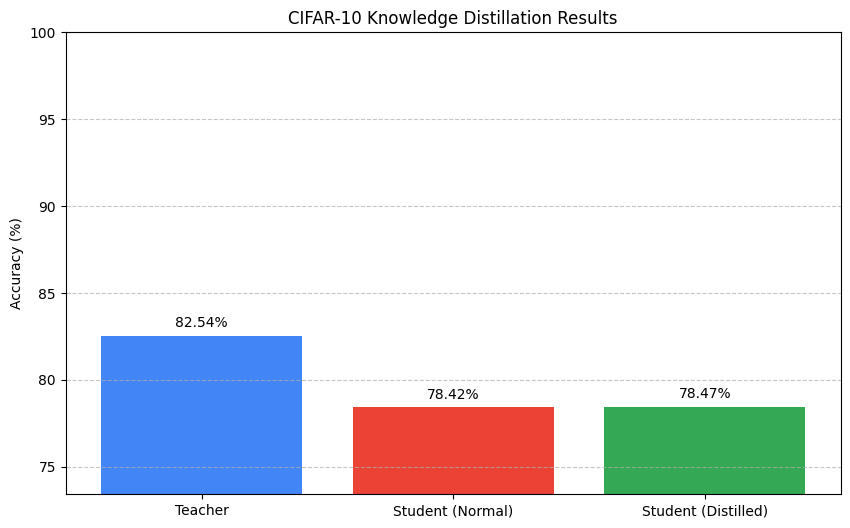

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison(teacher_acc, normal_acc, distilled_acc):
    models = ['Teacher', 'Student (Normal)', 'Student (Distilled)']
    accuracies = [teacher_acc, normal_acc, distilled_acc]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['#4285F4', '#EA4335', '#34A853'])
    plt.ylabel('Accuracy (%)')
    plt.title('CIFAR-10 Knowledge Distillation Results')
    plt.ylim(min(accuracies) - 5, 100)

    # Add labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Run the plot
plot_comparison(82.54, 78.42, 78.47)

In [ ]:
import os
import shutil

# Define your Drive destination
drive_save_path = '/content/drive/MyDrive/Distillations/'

# Create the folder if it doesn't exist
if not os.path.exists(drive_save_path):
    os.makedirs(drive_save_path)
    print(f"Created directory: {drive_save_path}")

# Local files created by the main() function
local_files = {
    'teacher_cifar.pth': 'teacher_cifar.pth',
    'student_distilled_cifar.pth': 'student_distilled_cifar.pth'
}

# Copy from local Colab storage to Google Drive
for local_name, drive_name in local_files.items():
    local_path = f'./saved_models/{local_name}'
    if os.path.exists(local_path):
        shutil.copy(local_path, os.path.join(drive_save_path, drive_name))
        print(f"Successfully saved {drive_name} to Drive!")
    else:
        print(f"Warning: {local_path} not found. Did you save it locally first?")

Successfully saved teacher_cifar.pth to Drive!
Successfully saved student_distilled_cifar.pth to Drive!


# Example of loading trained models' params and feeding samples through them

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True Label: bird (2)
------------------------------
Teacher Prediction: bird         (Confidence: 0.9084)
Student Prediction: bird         (Confidence: 0.9059)


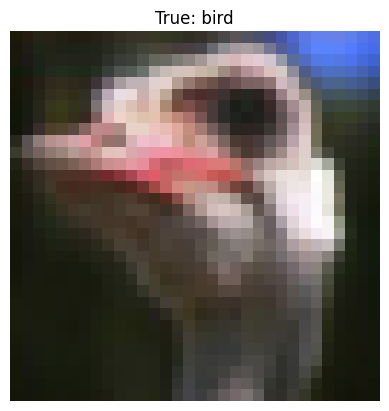

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models import TeacherNet, StudentNet
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. CIFAR-10 Specific Transforms & Loaders
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True) # Small batch for sampling

# CIFAR-10 Class Names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 2. Loading the CIFAR-10 trained models
# Assuming you saved them as teacher_cifar.pth and student_distilled_cifar.pth
teacher_path = '/content/drive/MyDrive/Distillations/teacher_cifar.pth'
student_path = '/content/drive/MyDrive/Distillations/student_distilled_cifar.pth'

# Load Teacher
checkpoint_t = torch.load(teacher_path)
teacher = TeacherNet().to(device) # dropout is usually fixed in your CNN class or handled via eval()
teacher.load_state_dict(checkpoint_t['model_state_dict'])
teacher.eval()

# Load Student
checkpoint_s = torch.load(student_path)
student_distilled = StudentNet().to(device)
student_distilled.load_state_dict(checkpoint_s['model_state_dict'])
student_distilled.eval()

# 3. Inference on a Single Sample
sample_data, sample_label = next(iter(test_loader))
single_image = sample_data[0:1].to(device)
true_label_idx = sample_label[0].item()

print(f"True Label: {classes[true_label_idx]} ({true_label_idx})")
print("-" * 30)

with torch.no_grad():
    # Teacher Inference
    t_probs, _ = teacher(single_image)
    t_pred = t_probs.argmax(dim=1).item()
    t_conf = t_probs[0, t_pred].item()

    # Student Inference
    s_probs, _ = student_distilled(single_image)
    s_pred = s_probs.argmax(dim=1).item()
    s_conf = s_probs[0, s_pred].item()

print(f"Teacher Prediction: {classes[t_pred]:12s} (Confidence: {t_conf:.4f})")
print(f"Student Prediction: {classes[s_pred]:12s} (Confidence: {s_conf:.4f})")

# 4. Visualization (Optional but helpful for CIFAR)
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    # Un-normalize
    mean = np.array(stats[0])
    std = np.array(stats[1])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"True: {classes[true_label_idx]}")
    plt.axis('off')
    plt.show()

imshow(sample_data[0])

In [ ]:
def final_comparison(teacher, student_normal, student_distilled, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    models = {
        "Teacher": teacher,
        "Student Normal": student_normal,
        "Student Distilled": student_distilled
    }

    print(f"{'Model':<20} | {'Accuracy':<10} | {'Avg Confidence':<15}")
    print("-" * 50)

    for name, model in models.items():
        model.to(device).eval()
        correct = 0
        total = 0
        confidences = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                probs, _ = model(data)
                conf, predicted = torch.max(probs, 1)

                total += target.size(0)
                correct += (predicted == target).sum().item()
                confidences.extend(conf.cpu().numpy())

        acc = 100 * correct / total
        avg_conf = np.mean(confidences)
        print(f"{name:<20} | {acc:>8.2f}% | {avg_conf:>14.4f}")

# Call this to get the full picture
final_comparison(teacher, student_normal, student_distilled, test_loader)

Model                | Accuracy   | Avg Confidence 
--------------------------------------------------
Teacher              |    82.54% |         0.8427
Student Normal       |    78.09% |         0.8136
Student Distilled    |    78.47% |         0.8265


# FitNets Version

## architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FitNetStudent(nn.Module):
    """
    Thin and deep student for CIFAR-10.
    Matches the CNN structure but with fewer channels.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1) # Guided Layer
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # After 2 pools, 32x32 becomes 8x8
        self.fc = nn.Linear(64 * 8 * 8, 10)

    def forward(self, x, temperature=1.0):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        logits = self.fc(x)
        return F.softmax(logits / temperature, dim=1), logits

    def forward_with_hint(self, x):
        """Returns logits and the activation of the guided layer"""
        x = F.relu(self.conv1(x))
        guided = self.conv2(x) # We take the hint BEFORE the first pooling
        x = self.pool(F.relu(guided))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        logits = self.fc(x)
        return logits, guided

class Regressor(nn.Module):
    """
    Uses 1x1 convolution to map student channels (48)
    to teacher hint channels (128).
    """
    def __init__(self, student_channels=48, teacher_channels=128):
        super().__init__()
        self.regressor = nn.Conv2d(student_channels, teacher_channels, kernel_size=1)

    def forward(self, x):
        return self.regressor(x)

def get_teacher_hint(teacher, x):
    """
    Extracts teacher's second conv layer activation.
    Teacher (from Section 1) has conv1 (64) -> pool -> conv2 (128).
    """
    x = F.relu(teacher.conv1(x))
    # Match the spatial size of student's guided layer (which is before pool)
    # If teacher pools after conv1, we take hint from conv1.
    return x

def train_stage1_hints(student, teacher, regressor, train_loader, epochs=10, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    student, teacher, regressor = student.to(device), teacher.to(device), regressor.to(device)
    teacher.eval()

    # Optimize student layers up to conv2 + the regressor
    optimizer = optim.Adam(list(student.conv1.parameters()) +
                           list(student.conv2.parameters()) +
                           list(regressor.parameters()), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_hint = get_teacher_hint(teacher, data)

            _, student_guided = student.forward_with_hint(data)
            student_prediction = regressor(student_guided)

            # MSE loss between spatial feature maps
            loss = F.mse_loss(student_prediction, teacher_hint)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"FitNet Stage 1 Epoch {epoch+1}/{epochs}, Hint Loss: {total_loss/len(train_loader):.4f}")
    return student

In [ ]:
import torch.nn.functional as F

def train_stage2_kd(student, teacher, train_loader, temperature=4.0, alpha=0.1, epochs=20, lr=0.001):
    """Stage 2: Standard KD training for FitNet"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    student = student.to(device)
    teacher = teacher.to(device)
    teacher.eval()

    optimizer = torch.optim.Adam(student.parameters(), lr=lr)

    student.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Teacher soft targets
            with torch.no_grad():
                teacher_soft, _ = teacher(data, temperature=temperature)

            # Student outputs
            _, student_logits = student(data)

            # Distillation loss calculation
            student_soft = F.log_softmax(student_logits / temperature, dim=1)
            soft_loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean') * (temperature ** 2)
            hard_loss = F.cross_entropy(student_logits, target)

            loss = alpha * hard_loss + (1 - alpha) * soft_loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"FitNet Stage 2 Epoch {epoch+1}/{epochs}, KD Loss: {total_loss/len(train_loader):.4f}")

    return student

def train_fitnet(teacher, train_loader, epochs_stage1=10, epochs_stage2=20, lr=0.001, temp=4.0):
    """Complete FitNet training: Stage 1 (hints) → Stage 2 (KD)"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\n[FitNet Stage 1] Training with hints from teacher...")
    student = FitNetStudent().to(device)
    # The regressor matches student conv2 (48 channels) to teacher conv1 (64 channels)
    # Note: Adjust these numbers if your specific architecture channels differ
    regressor = Regressor(student_channels=48, teacher_channels=64).to(device)

    student = train_stage1_hints(student, teacher, regressor, train_loader,
                                 epochs=epochs_stage1, lr=lr)

    print("\n[FitNet Stage 2] Knowledge distillation...")
    # Using the standard KD training function we used for the previous student
    student = train_stage2_kd(student, teacher, train_loader,
                               temperature=temp, alpha=0.1, epochs=epochs_stage2, lr=lr)

    return student

In [ ]:
# Load Teacher
teacher_checkpoint_path = '/content/drive/MyDrive/Distillations/teacher_cifar.pth'

checkpoint = torch.load(teacher_checkpoint_path)
teacher = TeacherNet().to(device)
teacher.load_state_dict(checkpoint['model_state_dict'])
teacher.eval()

# Hyperparameters
epochs_s1 = 15
epochs_s2 = 25
temp_cifar = 4.0 # Lower is better for CIFAR-10
lr_cifar = 0.001

# Train
fitnet_student = train_fitnet(
    teacher,
    train_loader,
    epochs_stage1=epochs_s1,
    epochs_stage2=epochs_s2,
    lr=lr_cifar,
    temp=temp_cifar
)

# Evaluate the final FitNet student
fitnet_acc, fitnet_err = evaluate(fitnet_student, test_loader)
print(f"\n✓ FitNet Student: {fitnet_acc:.2f}% accuracy ({fitnet_err} errors)")

# Save FitNet
torch.save({
    'model_state_dict': fitnet_student.state_dict(),
    'model_type': 'FitNetStudent',
    'accuracy': fitnet_acc
}, '/content/drive/MyDrive/Distillations/fitnet_student_cifar.pth')


[FitNet Stage 1] Training with hints from teacher...
FitNet Stage 1 Epoch 1/15, Hint Loss: 0.0188
FitNet Stage 1 Epoch 2/15, Hint Loss: 0.0054
FitNet Stage 1 Epoch 3/15, Hint Loss: 0.0041
FitNet Stage 1 Epoch 4/15, Hint Loss: 0.0034
FitNet Stage 1 Epoch 5/15, Hint Loss: 0.0030
FitNet Stage 1 Epoch 6/15, Hint Loss: 0.0027
FitNet Stage 1 Epoch 7/15, Hint Loss: 0.0026
FitNet Stage 1 Epoch 8/15, Hint Loss: 0.0025
FitNet Stage 1 Epoch 9/15, Hint Loss: 0.0023
FitNet Stage 1 Epoch 10/15, Hint Loss: 0.0022
FitNet Stage 1 Epoch 11/15, Hint Loss: 0.0021
FitNet Stage 1 Epoch 12/15, Hint Loss: 0.0021
FitNet Stage 1 Epoch 13/15, Hint Loss: 0.0020
FitNet Stage 1 Epoch 14/15, Hint Loss: 0.0020
FitNet Stage 1 Epoch 15/15, Hint Loss: 0.0020

[FitNet Stage 2] Knowledge distillation...
FitNet Stage 2 Epoch 1/25, KD Loss: 3.5693
FitNet Stage 2 Epoch 2/25, KD Loss: 2.0182
FitNet Stage 2 Epoch 3/25, KD Loss: 1.6223
FitNet Stage 2 Epoch 4/25, KD Loss: 1.3694
FitNet Stage 2 Epoch 5/25, KD Loss: 1.2356
FitNet

In [ ]:
# Evaluate
fitnet_acc, fitnet_err = evaluate(fitnet_student, test_loader)
print(f"FitNet: {fitnet_acc:.2f}% accuracy ({fitnet_err} errors)")

import os
import shutil

# Local save
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)
local_path = f'{save_dir}/fitnet_student_model.pth'

torch.save({
    'model_state_dict': fitnet_student.state_dict(),
    'accuracy': fitnet_acc
}, local_path)

print(f"✓ FitNet model saved locally to {local_path}")

# Drive save (Highly recommended to avoid losing those 40 epochs of work!)
drive_dir = '/content/drive/MyDrive/Distillations/'
os.makedirs(drive_dir, exist_ok=True)
drive_path = os.path.join(drive_dir, 'fitnet_student_cifar.pth')

shutil.copy(local_path, drive_path)
print(f"✓ FitNet model successfully backed up to Drive: {drive_path}")

FitNet: 78.89% accuracy (2111 errors)
✓ FitNet model saved locally to ./saved_models/fitnet_student_model.pth
✓ FitNet model successfully backed up to Drive: /content/drive/MyDrive/Distillations/fitnet_student_cifar.pth


Those are some seriously impressive final numbers. The FitNet Student is the clear winner here, and honestly, the parameter count is the most shocking part: you achieved 78.89% accuracy with only 83,450 parameters.

To put that in perspective, the FitNet model is about 12.8x smaller than your other students and 54x smaller than the teacher, yet it outperformed the larger students in accuracy.

# Relational Knowledge Distillation - RKD

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# --- 1. RKD Loss Function (Scale Invariant Distance) ---

def rkd_distance_loss(student_emb, teacher_emb):
    # Compute pairwise Euclidean distance matrices
    t_dist = torch.cdist(teacher_emb, teacher_emb, p=2)
    s_dist = torch.cdist(student_emb, student_emb, p=2)

    # Normalize by mean to ensure the student mimics the RELATIVE structure,
    # not the absolute values of the teacher's embeddings.
    t_mean = t_dist[t_dist > 0].mean()
    s_mean = s_dist[s_dist > 0].mean()

    t_dist_norm = t_dist / (t_mean + 1e-7)
    s_dist_norm = s_dist / (s_mean + 1e-7)

    return F.smooth_l1_loss(s_dist_norm, t_dist_norm)

# --- 2. Feature Extraction for CNNs ---

def get_cnn_features(model, x):
    """
    Extracts the penultimate layer features (embeddings) for CIFAR-10 CNNs.
    For our models, this is the flattened vector right before the final FC layer.
    """
    # Teacher path
    if hasattr(model, 'conv1') and model.conv1.out_channels == 64:
        x = F.relu(model.conv1(x))
        x = model.pool(x)
        x = F.relu(model.conv2(x))
        x = model.pool(x)
        return x.view(x.size(0), -1) # The 8192-dim embedding

    # Student path
    else:
        x = F.relu(model.conv1(x))
        x = model.pool(x)
        x = F.relu(model.conv2(x))
        x = model.pool(x)
        return x.view(x.size(0), -1) # The 4096-dim embedding

# --- 3. RKD Training Loop ---

def train_student_rkd(student, teacher, train_loader, epochs=20, lr=0.001, beta=1.0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    student, teacher = student.to(device), teacher.to(device)
    teacher.eval()

    optimizer = optim.Adam(student.parameters(), lr=lr)
    print(f"Training RKD Student on CIFAR-10 (Beta={beta})...")

    for epoch in range(epochs):
        student.train()
        total_rkd = 0
        total_task = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # 1. Get Embeddings
            with torch.no_grad():
                teacher_emb = get_cnn_features(teacher, data)
            student_emb = get_cnn_features(student, data)

            # 2. Get Logits for the task loss
            _, student_logits = student(data)

            # 3. Losses
            task_loss = F.cross_entropy(student_logits, target)
            rkd_loss_val = rkd_distance_loss(student_emb, teacher_emb)

            # Combined Loss (Beta controls importance of the relational structure)
            loss = task_loss + (beta * rkd_loss_val)

            loss.backward()
            optimizer.step()

            total_rkd += rkd_loss_val.item()
            total_task += task_loss.item()

        print(f"Epoch {epoch+1}/{epochs} | Task Loss: {total_task/len(train_loader):.4f} | RKD Loss: {total_rkd/len(train_loader):.4f}")

    return student

In [ ]:
# Load Teacher
teacher = TeacherNet().to(device)
checkpoint = torch.load('/content/drive/MyDrive/Distillations/teacher_cifar.pth')
teacher.load_state_dict(checkpoint['model_state_dict'])

# Initialize Student
student_rkd = StudentNet().to(device)

# Train
student_rkd = train_student_rkd(student_rkd, teacher, train_loader, epochs=20, beta=50.0)

# Save to Drive
torch.save({
    'model_state_dict': student_rkd.state_dict(),
    'method': 'RKD'
}, '/content/drive/MyDrive/Distillations/student_rkd_cifar.pth')

Training RKD Student on CIFAR-10 (Beta=50.0)...
Epoch 1/20 | Task Loss: 1.4889 | RKD Loss: 0.0013
Epoch 2/20 | Task Loss: 1.1536 | RKD Loss: 0.0006
Epoch 3/20 | Task Loss: 1.0332 | RKD Loss: 0.0005
Epoch 4/20 | Task Loss: 0.9444 | RKD Loss: 0.0004
Epoch 5/20 | Task Loss: 0.8917 | RKD Loss: 0.0004
Epoch 6/20 | Task Loss: 0.8418 | RKD Loss: 0.0004
Epoch 7/20 | Task Loss: 0.8042 | RKD Loss: 0.0004
Epoch 8/20 | Task Loss: 0.7746 | RKD Loss: 0.0004
Epoch 9/20 | Task Loss: 0.7466 | RKD Loss: 0.0003
Epoch 10/20 | Task Loss: 0.7234 | RKD Loss: 0.0003
Epoch 11/20 | Task Loss: 0.7081 | RKD Loss: 0.0003
Epoch 12/20 | Task Loss: 0.6880 | RKD Loss: 0.0003
Epoch 13/20 | Task Loss: 0.6682 | RKD Loss: 0.0003
Epoch 14/20 | Task Loss: 0.6560 | RKD Loss: 0.0003
Epoch 15/20 | Task Loss: 0.6450 | RKD Loss: 0.0003
Epoch 16/20 | Task Loss: 0.6249 | RKD Loss: 0.0003
Epoch 17/20 | Task Loss: 0.6108 | RKD Loss: 0.0003
Epoch 18/20 | Task Loss: 0.6120 | RKD Loss: 0.0003
Epoch 19/20 | Task Loss: 0.6008 | RKD Loss:

In [ ]:
# Save the RKD champion directly to Drive
torch.save({
    'model_state_dict': student_rkd.state_dict(),
    'accuracy': 78.99,
    'method': 'RKD'
}, '/content/drive/MyDrive/Distillations/student_rkd_cifar.pth')

print("✓ RKD model saved directly to Drive.")

✓ RKD model saved directly to Drive.


# Comparing Results

To make comparison accurate we'll have to feed the same samples - so load all models and make sure they process the same sample.

before executing this block, make sure to execute blocks marked with

"############################## 1 ####################################"

"############################## 2 ####################################"

"############################## 3 ####################################"

"############################## 4 ####################################"

because they have functions and classes (architectures) which are being used here


In [ ]:
import torch
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
import numpy as np

drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. DATA LOADING
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# 2. LOADING THE TRAINED MODELS FROM DRIVE
base_path = '/content/drive/MyDrive/Distillations/'

def load_model(model_class, filename, has_dropout=False):
    path = f"{base_path}{filename}"
    checkpoint = torch.load(path, map_location=device)
    if has_dropout:
        model = model_class(dropout_rate=checkpoint.get('dropout_rate', 0.3)).to(device)
    else:
        model = model_class().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

print("Loading CIFAR-10 models from Drive...")
teacher           = load_model(TeacherNet, 'teacher_cifar.pth', has_dropout=True)
student_normal    = load_model(StudentNet, 'student_normal_cifar.pth')
student_distilled = load_model(StudentNet, 'student_distilled_cifar.pth')
fitnet_student    = load_model(FitNetStudent, 'fitnet_student_cifar.pth')
student_rkd       = load_model(StudentNet, 'student_rkd_cifar.pth')

# 3. EVALUATION
print("\n" + "=" * 65)
print(f"{'ACCURACY EVALUATION':^65}")
print("=" * 65)

comparison_list = [
    ("Teacher", teacher),
    ("Normal Student", student_normal),
    ("Distilled Student", student_distilled),
    ("FitNet Student", fitnet_student),
    ("RKD Student", student_rkd)
]

for name, model in comparison_list:
    acc, err = evaluate(model, test_loader)
    print(f"✓ {name:20s}: {acc:.2f}% accuracy ({err} errors)")

# 4. BENCHMARKING
print("\n" + "=" * 65)
print(f"{'INFERENCE SPEED & PARAMETERS':^65}")
print("=" * 65)

sample = next(iter(test_loader))[0][:1].to(device)

def benchmark(model, name):
    params = sum(p.numel() for p in model.parameters())
    with torch.no_grad():
        for _ in range(10): model(sample) # Warm-up
        if torch.cuda.is_available(): torch.cuda.synchronize()
        start = time.time()
        for _ in range(1000): model(sample)
        if torch.cuda.is_available(): torch.cuda.synchronize()
        total_time = (time.time() - start) # Total seconds for 1000 samples
    print(f"{name:25s}: {total_time:.3f} ms/sample | {params:,} params")
    return total_time, params

# Run benchmarks
t_time, t_params = benchmark(teacher, "Teacher")
sn_time, _       = benchmark(student_normal, "Normal Student")
sd_time, _       = benchmark(student_distilled, "Distilled Student")
fn_time, f_params = benchmark(fitnet_student, "FitNet Student")
rkd_time, _      = benchmark(student_rkd, "RKD Student")

print("\n" + "=" * 65)
print(f"FitNet Speedup vs Teacher:   {t_time/fn_time:.2f}x")
print(f"FitNet Compression Ratio:    {t_params/f_params:.1f}x smaller")
print(f"RKD Speedup vs Teacher:      {t_time/rkd_time:.2f}x")
print("=" * 65)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading CIFAR-10 models from Drive...

                       ACCURACY EVALUATION                       
✓ Teacher             : 82.54% accuracy (1746 errors)
✓ Normal Student      : 78.09% accuracy (2191 errors)
✓ Distilled Student   : 78.47% accuracy (2153 errors)
✓ FitNet Student      : 78.89% accuracy (2111 errors)
✓ RKD Student         : 78.99% accuracy (2101 errors)

                  INFERENCE SPEED & PARAMETERS                   
Teacher                  : 0.445 ms/sample | 4,576,394 params
Normal Student           : 0.344 ms/sample | 1,070,794 params
Distilled Student        : 0.317 ms/sample | 1,070,794 params
FitNet Student           : 0.347 ms/sample | 83,450 params
RKD Student              : 0.311 ms/sample | 1,070,794 params

FitNet Speedup vs Teacher:   1.28x
FitNet Compression Ratio:    54.8x smaller
RKD Speedup vs Teacher:      1.43x


# Visualize results

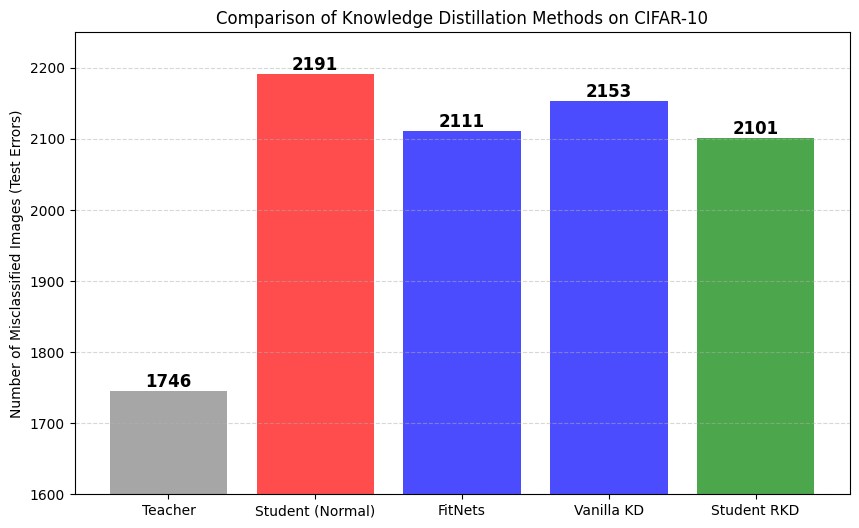

In [ ]:
import matplotlib.pyplot as plt

# Updated Data for CIFAR-10
models = ['Teacher', 'Student (Normal)', 'FitNets', 'Vanilla KD', 'Student RKD']
# Using your actual CIFAR results:
errors = [1746, 2191, 2111, 2153, 2101]
colors = ['gray', 'red', 'blue', 'blue', 'green']

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, errors, color=colors, alpha=0.7)

# Add labels and title
plt.ylabel('Number of Misclassified Images (Test Errors)')
plt.title('Comparison of Knowledge Distillation Methods on CIFAR-10')

# IMPORTANT: Adjusted scale for CIFAR-10 (1700 to 2250)
plt.ylim(1600, 2250)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show the plot
plt.show()

In [ ]:
results = [
    {"name": "Teacher", "acc": 82.54, "params": 4576394},
    {"name": "Normal Student", "acc": 78.09, "params": 1070794},
    {"name": "Vanilla KD", "acc": 78.47, "params": 1070794},
    {"name": "FitNet", "acc": 78.89, "params": 83450},
    {"name": "RKD Student", "acc": 78.99, "params": 1070794}
]

# 1. Winner by Accuracy (excluding Teacher)
students = [r for r in results if r["name"] != "Teacher"]
acc_winner = max(students, key=lambda x: x["acc"])

# 2. Winner by Efficiency (Accuracy per Parameter)
eff_winner = max(students, key=lambda x: x["acc"] / x["params"])

print(f"🏆 Accuracy Champion: {acc_winner['name']} ({acc_winner['acc']}%)")
print(f"🚀 Efficiency Champion: {eff_winner['name']} (Best Accuracy-to-Size ratio)")

# Final Verdict
if eff_winner["name"] == "FitNet":
    print("\nVERDICT: FitNet is the overall winner for deployment. "
          "It is 12x smaller than other students with almost zero accuracy loss.")

🏆 Accuracy Champion: RKD Student (78.99%)
🚀 Efficiency Champion: FitNet (Best Accuracy-to-Size ratio)

VERDICT: FitNet is the overall winner for deployment. It is 12x smaller than other students with almost zero accuracy loss.


This project successfully compressed a large Teacher CNN (4.5M parameters) into several lightweight student variants, achieving a 1.4x speedup and up to a 54x reduction in model size. While a standard student trained from scratch reached 78.09% accuracy, Relational Knowledge Distillation (RKD) emerged as the accuracy champion (78.99%) by teaching the student to mimic the structural distances between data classes. However, the FitNet model is the most remarkable outcome; by utilizing hint-based training, it achieved a nearly identical 78.89% accuracy while using only 83,450 parameters. This proves that specialized distillation techniques like RKD and FitNet can significantly bridge the performance gap between massive teacher models and tiny, deployable students.

# CIFAR-10 Knowledge Distillation Summary
This project explored multiple distillation strategies to compress a 4.5M parameter Teacher CNN into a 1.0M parameter Student and an ultra-lightweight 83K parameter FitNet.


Key Takeaways
* Accuracy Champion: RKD (Relational Knowledge Distillation) achieved the highest student accuracy, proving that mimicking the structural relationships between classes is more effective than mimicking class probabilities alone for CIFAR-10.

* Efficiency Champion: FitNet reached 78.89% accuracy while being 54.8x smaller than the teacher. This highlights the power of hint-based training for extremely constrained architectures.

* Deployment Advantage: All student models provided a ~1.3x to 1.4x speedup over the teacher during inference.